In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [3]:
# Showing one example
model_type = 'blip'
data_loader = loaders.DataLoader(data_source = "meld", model_type=model_type, logger=logger)
df_table = data_loader.load_annotations_df()
df_table = df_table.rename(columns={0: "image_id", 1: "utterance", 2: "index", 3: "utterance_id", 4: "supercategories", 5: "sentiment"})
#k = 5
#data_loader.showing_example(k)
#data_loader.show_clip_similarity(k, df_table, model, preprocess)

# Define OOD Categories below

In [4]:
import gensim.downloader as api
wv_model = api.load("word2vec-google-news-300")

In [5]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()
new_supercategories = ['surprise', 
                   'anger', 
                   'neutral',
                   'joy',
                   'sadness',
                   'disgust',
                   'fear']
lemmatized_supercategories = [lemmatizer.lemmatize(word) for word in new_supercategories]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WFYIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
cosine_similarity_list = []
for category_a in new_supercategories:
    cosine_sim_current = 0
    for category_b in new_supercategories:
        text_tokens_a = wv_model[category_a]
        text_tokens_b = wv_model[category_b]
        cosine_sim_current += 1 - np.dot(text_tokens_a, text_tokens_b) / (np.linalg.norm(text_tokens_a) * np.linalg.norm(text_tokens_b))
    print(f"Cosine similarity for {category_a} is: {cosine_sim_current - 1}")
    cosine_similarity_list.append(cosine_sim_current - 1)

Cosine similarity for surprise is: 3.6490321159362793
Cosine similarity for anger is: 2.8400544496253133
Cosine similarity for neutral is: 4.905191642232239
Cosine similarity for joy is: 3.080360010266304
Cosine similarity for sadness is: 2.8926704302430153
Cosine similarity for disgust is: 2.7843317724764347
Cosine similarity for fear is: 3.196864504367113


In [7]:
from nltk.corpus import wordnet as wn

wn_list = []
for category_a in lemmatized_supercategories:
    sim_current = 0
    for category_b in lemmatized_supercategories:
        similarity = 1 - wn.synset(f"{category_a}.n.01").path_similarity(wn.synset(f"{category_b}.n.01"))
        #logger.info(f"Similarity between {category_a} and {category_b} is: {similarity}")
        sim_current += similarity
    logger.info(f"Sum similarity for {category_a} is: {sim_current - 1}")
    wn_list.append(sim_current - 1)

2024-07-11 23:41:42,696 - notebook_logger - INFO - Sum similarity for surprise is: 3.8590909090909085
2024-07-11 23:41:42,697 - notebook_logger - INFO - Sum similarity for anger is: 3.5924242424242427
2024-07-11 23:41:42,698 - notebook_logger - INFO - Sum similarity for neutral is: 4.445454545454545
2024-07-11 23:41:42,699 - notebook_logger - INFO - Sum similarity for joy is: 3.5924242424242427
2024-07-11 23:41:42,700 - notebook_logger - INFO - Sum similarity for sadness is: 3.6500000000000004
2024-07-11 23:41:42,701 - notebook_logger - INFO - Sum similarity for disgust is: 3.8590909090909093
2024-07-11 23:41:42,702 - notebook_logger - INFO - Sum similarity for fear is: 3.5924242424242427


In [8]:
final_average = {}
for i in range(len(new_supercategories)):
    #logger.info(f"Category: {new_supercategories[i]} - Cosine Similarity: {cosine_similarity_list[i]} - WordNet Similarity: {wn_list[i]}")
    average = (cosine_similarity_list[i] + wn_list[i]) / 2
    logger.info(f"Category: {new_supercategories[i]} Average: {average}")
    final_average[new_supercategories[i]] = average

df = pd.DataFrame(list(final_average.items()), columns=['Key', 'Value'])
df.sort_values(by='Value', ascending=False, inplace=True)
df

2024-07-11 23:41:42,709 - notebook_logger - INFO - Category: surprise Average: 3.754061512513594
2024-07-11 23:41:42,709 - notebook_logger - INFO - Category: anger Average: 3.216239346024778
2024-07-11 23:41:42,710 - notebook_logger - INFO - Category: neutral Average: 4.675323093843392
2024-07-11 23:41:42,710 - notebook_logger - INFO - Category: joy Average: 3.3363921263452734
2024-07-11 23:41:42,710 - notebook_logger - INFO - Category: sadness Average: 3.271335215121508
2024-07-11 23:41:42,711 - notebook_logger - INFO - Category: disgust Average: 3.321711340783672
2024-07-11 23:41:42,711 - notebook_logger - INFO - Category: fear Average: 3.394644373395678


,Key,Value
2,neutral,4.675323
0,surprise,3.754062
6,fear,3.394644
3,joy,3.336392
5,disgust,3.321711
4,sadness,3.271335
1,anger,3.216239


In [9]:
ood_category = ['anger']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ood_category) else 1)
df_table['OOD'].value_counts()

OOD
1    8879
0    1109
Name: count, dtype: int64

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [10]:
if data_loader.data_source == "real":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    ## Dialogue Processing
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)

    ## Image Processing
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/QA_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/QA_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

elif data_loader.data_source == "meld":
    df_dialogue = data_loader.load_dialogue_df()
    df_image = data_loader.load_image_df()
    df_table[f"dialogue_{model_type}"] = list(df_dialogue)
    df_table[f"image_{model_type}"] = list(df_image)
    

In [11]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories'].apply(lambda x: [x])))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [12]:
def image_text_similarity(row):
    a = row[f'dialogue_{model_type}']
    b = row[f'image_{model_type}']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)

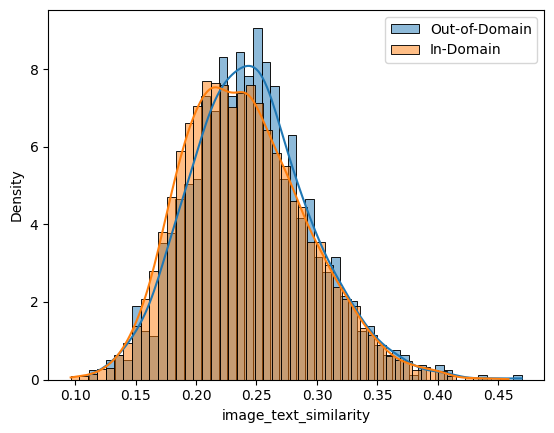

In [13]:
sns.histplot(df_table[df_table['OOD'] == 0]['image_text_similarity'], bins=50, kde=True, label='Out-of-Domain', stat='density')
sns.histplot(df_table[df_table['OOD'] == 1]['image_text_similarity'], bins=50, kde=True, label='In-Domain', stat='density')
plt.legend()

In [14]:
#print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score_max'].values, 0.95))
#print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['image_score'].values, 0.95))
#print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score_max'].values, 0.95))
#print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, df_table['dialogue_score'].values, 0.95))
#print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
#print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
#print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity'].values, 0.95))
#print("Overall Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_sum'].values, 0.95))
#print("Overall Transform Max:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_transform'].values, 0.95))
#print("Overall Transform Sum:", ev.fpr_evaluation(df_table['OOD'].values, df_table['overall_simialrity_transform_sum'].values, 0.95))

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 
import importlib
importlib.reload(model)

image_model_loader = model.model_loader(logger=logger,
                                  input_size=256,
                                  num_epochs=6,
                                  output_size=len(ind_category),
                                  learning_rate=0.001,
                                  proportion = 0.8,
                                  seed = 20)

dialogue_model_loader = model.model_loader(logger=logger,
                                    input_size=256,
                                    num_epochs=6,
                                    output_size=len(ind_category),
                                    learning_rate=0.001,
                                    seed = 20)

(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test
) = image_model_loader.create_dataset(data_loader, df_table, add_mismatch = True, mismatch_num = 500, used_model = model_type)

df_test['image_text_similarity'] = df_test.apply(image_text_similarity, axis=1)

2024-07-11 23:43:46,956 - notebook_logger - INFO - Setting random seed: 20
2024-07-11 23:43:46,961 - notebook_logger - INFO - Setting random seed: 20


In [39]:
df_test[(df_test['OOD'] == 0) & (df_test['supercategories'] != 'anger')][['utterance', 'supercategories', 'image_text_similarity']].head(20)

,utterance,supercategories,image_text_similarity
2886,I'll be there.,neutral,0.208730
2887,Are you serious?!,neutral,0.197625
2888,"Quack, quack..",surprise,0.240580
2889,Terry!,sadness,0.218212
2890,No drinks near the bucket!,neutral,0.221795
2891,You're right.,neutral,0.228389
2892,"Oh Phoebe, that's a great story.",surprise,0.319198
2893,Hey he's wearing a sweater.,fear,0.396935
2895,"Ross, but me down for another box of the mint ...",surprise,0.221727
2896,You missed the exit!,neutral,0.221535


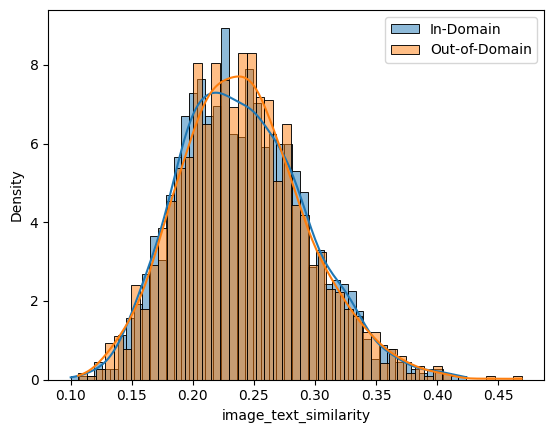

In [28]:
sns.histplot(df_test[df_test['OOD'] == 1]['image_text_similarity'], kde=True, label='In-Domain', bins=50, stat='density')
sns.histplot(df_test[df_test['OOD'] == 0]['image_text_similarity'], kde=True, label='Out-of-Domain', bins=50, stat='density')
plt.legend()

In [29]:
image_model_loader.train_model(X_train_image, Y_train, X_test_image, Y_test, ood_category = '_'.join(ood_category))

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]
2024-07-11 23:43:57,723 - notebook_logger - INFO - Model saved at f:\Github\multimodal_ood\models\DNN\models\DNN\image_model_anger_6_0.001.pth


In [30]:
dialogue_model_loader.train_model(X_train_dialogue, Y_train, X_test_dialogue, Y_test, ood_category = '_'.join(ood_category))

100%|██████████| 6/6 [00:06<00:00,  1.04s/it]
2024-07-11 23:44:05,321 - notebook_logger - INFO - Model saved at f:\Github\multimodal_ood\models\DNN\models\DNN\image_model_anger_6_0.001.pth


In [31]:
score_type_list = ["prob", "energy", "logits", "msp"]

for score_type in score_type_list:
    image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_max_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_image'] 
    df_test[f'{score_type}_max_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_sum_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_image']
    df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_dialogue']

    df_test[f'{score_type}_overall_simialrity_max'] = df_test[f'{score_type}_max_image'] + df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_overall_simialrity_max_transform'] =  df_test[f'{score_type}_max_image_tranform'] + df_test[f'{score_type}_max_dialogue_tranform']
    if score_type in ["energy", "logits", "prob"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test[f'{score_type}_sum_image'] + df_test[f'{score_type}_sum_dialogue']
        df_test[f'{score_type}_overall_simialrity_sum_transform'] = df_test[f'{score_type}_sum_image_tranform'] + df_test[f'{score_type}_sum_dialogue_tranform']

2024-07-11 23:44:07,014 - notebook_logger - INFO - Test Loss: 0.3049, Test Accuracy: 0.3471
2024-07-11 23:44:07,099 - notebook_logger - INFO - Test Loss: 0.2961, Test Accuracy: 0.4681
2024-07-11 23:44:07,186 - notebook_logger - INFO - Test Loss: 0.3049, Test Accuracy: 0.3471
2024-07-11 23:44:07,270 - notebook_logger - INFO - Test Loss: 0.2961, Test Accuracy: 0.4681
2024-07-11 23:44:07,406 - notebook_logger - INFO - Test Loss: 0.3049, Test Accuracy: 0.3471
2024-07-11 23:44:07,493 - notebook_logger - INFO - Test Loss: 0.2961, Test Accuracy: 0.4681
2024-07-11 23:44:07,585 - notebook_logger - INFO - Test Loss: 0.3049, Test Accuracy: 0.3471
2024-07-11 23:44:07,671 - notebook_logger - INFO - Test Loss: 0.2961, Test Accuracy: 0.4681


f:\Github\multimodal_ood\utils\plot_figure.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_ood_scores, shade=True, color='blue', alpha=0.5, label='In Distribution')
f:\Github\multimodal_ood\utils\plot_figure.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ood_scores, shade=True, color='red', alpha=0.5, label='Out of Distribution')


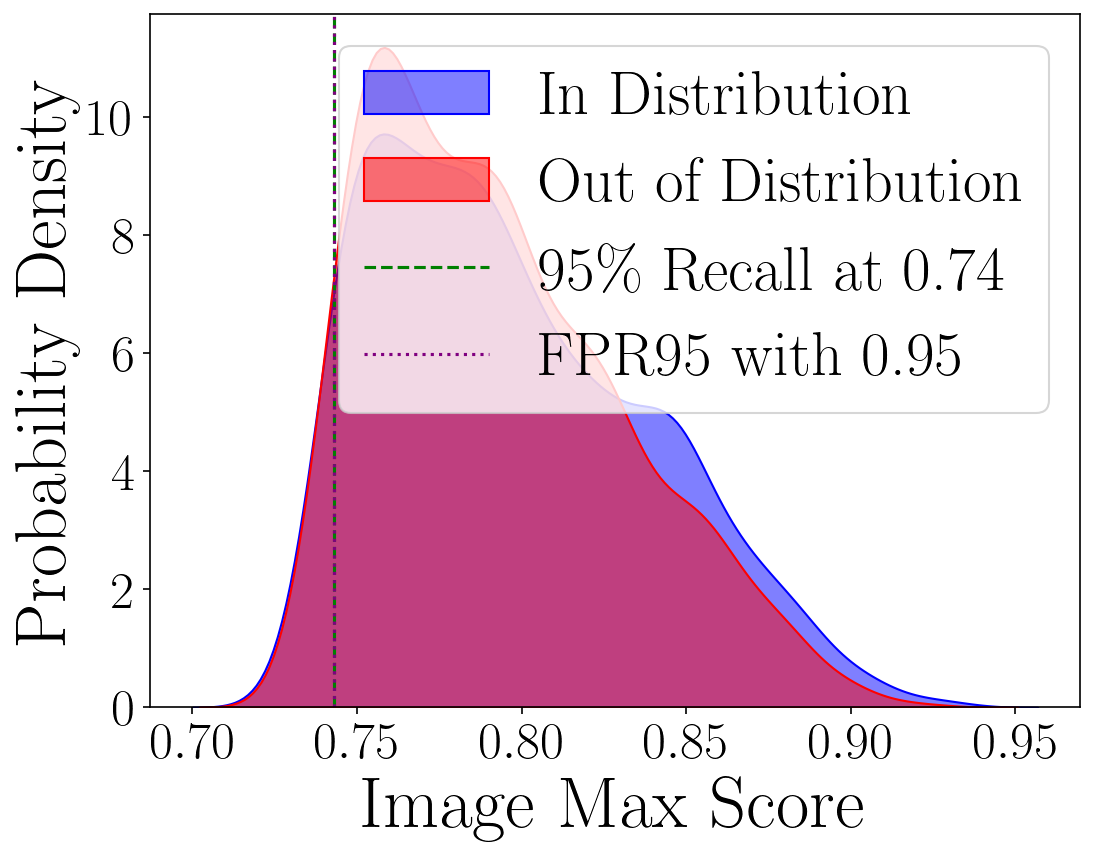

f:\Github\multimodal_ood\utils\plot_figure.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_ood_scores, shade=True, color='blue', alpha=0.5, label='In Distribution')
f:\Github\multimodal_ood\utils\plot_figure.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ood_scores, shade=True, color='red', alpha=0.5, label='Out of Distribution')


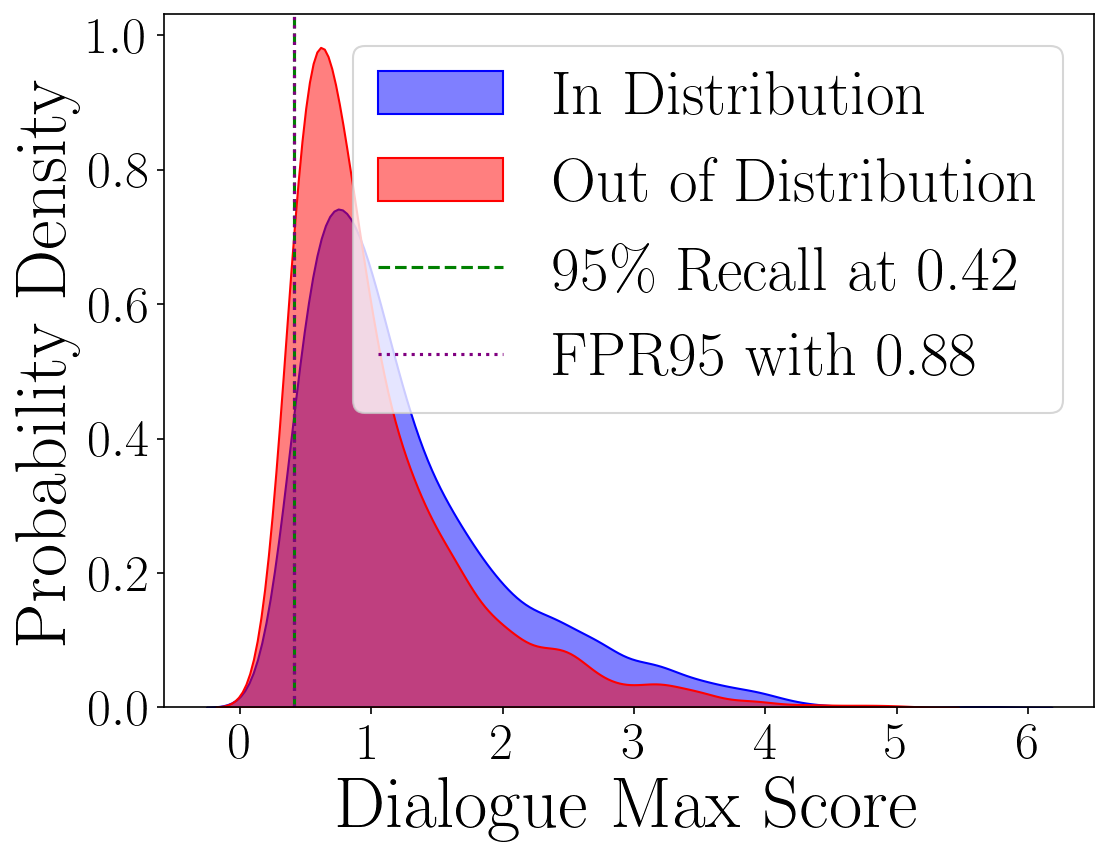

f:\Github\multimodal_ood\utils\plot_figure.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_ood_scores, shade=True, color='blue', alpha=0.5, label='In Distribution')
f:\Github\multimodal_ood\utils\plot_figure.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ood_scores, shade=True, color='red', alpha=0.5, label='Out of Distribution')


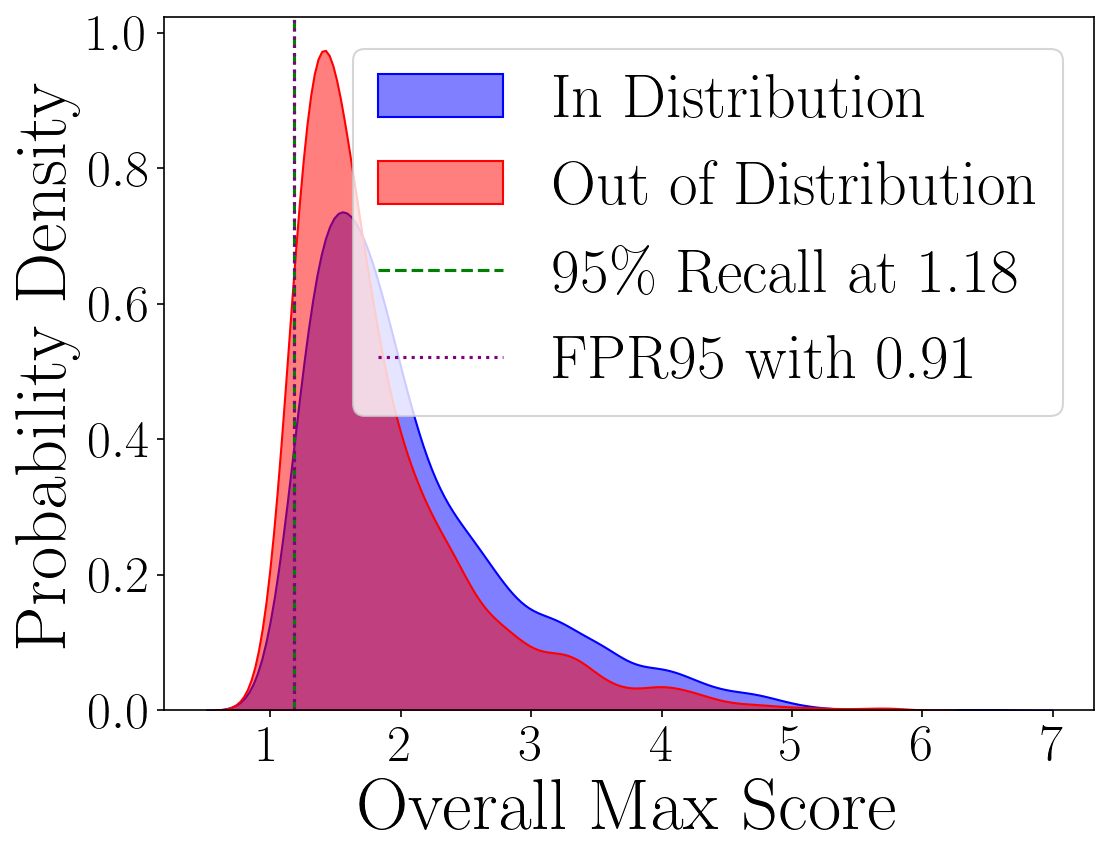

f:\Github\multimodal_ood\utils\plot_figure.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_ood_scores, shade=True, color='blue', alpha=0.5, label='In Distribution')
f:\Github\multimodal_ood\utils\plot_figure.py:58: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ood_scores, shade=True, color='red', alpha=0.5, label='Out of Distribution')


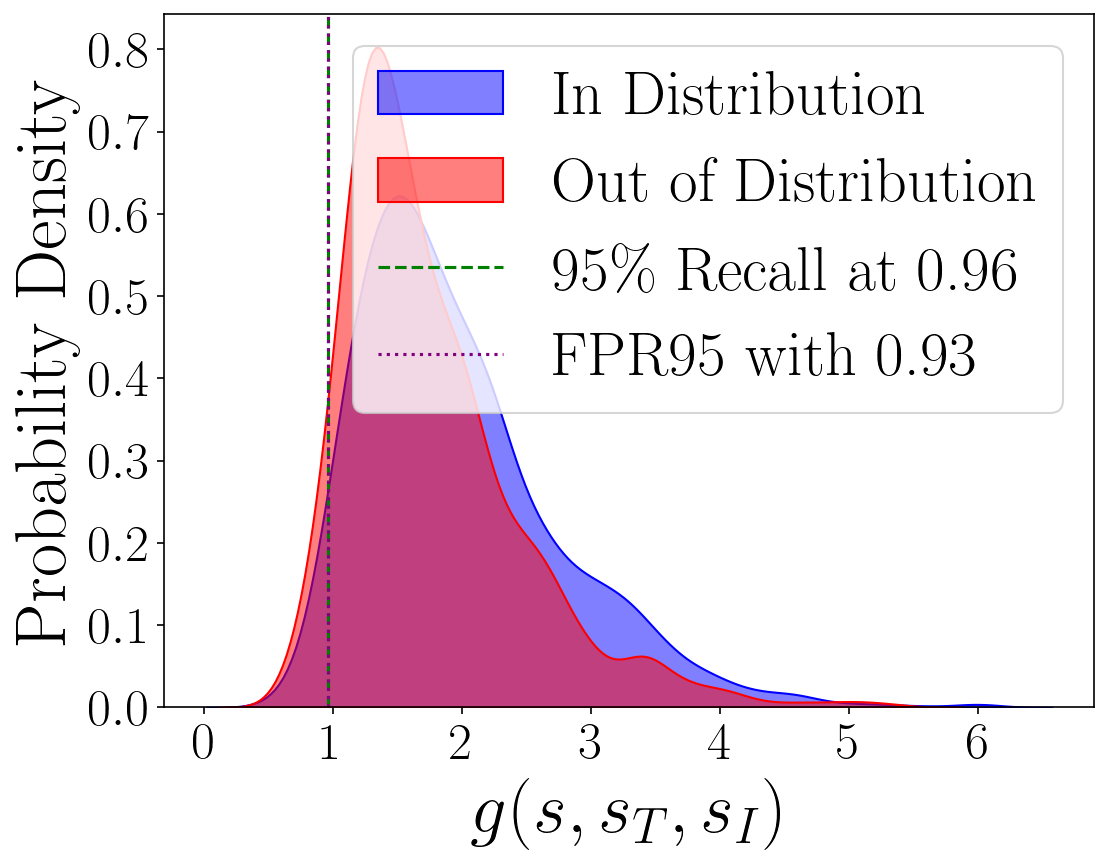

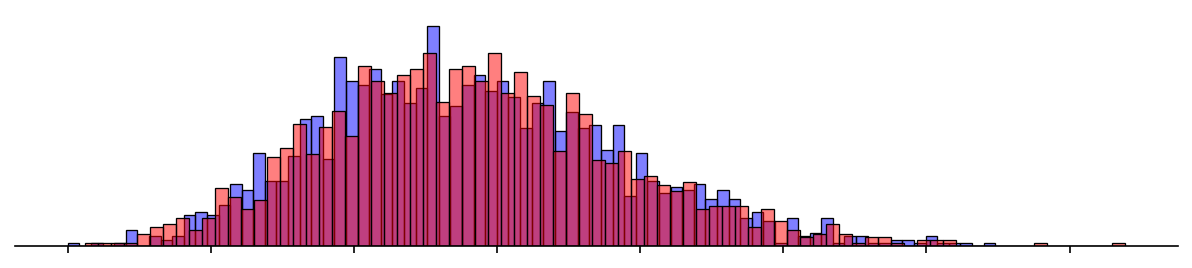

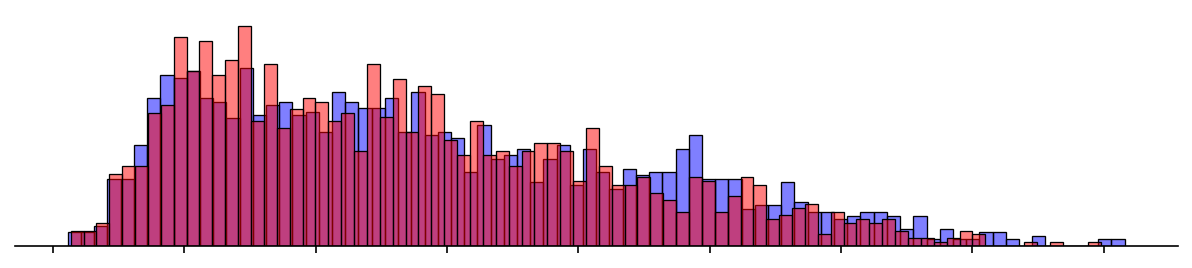

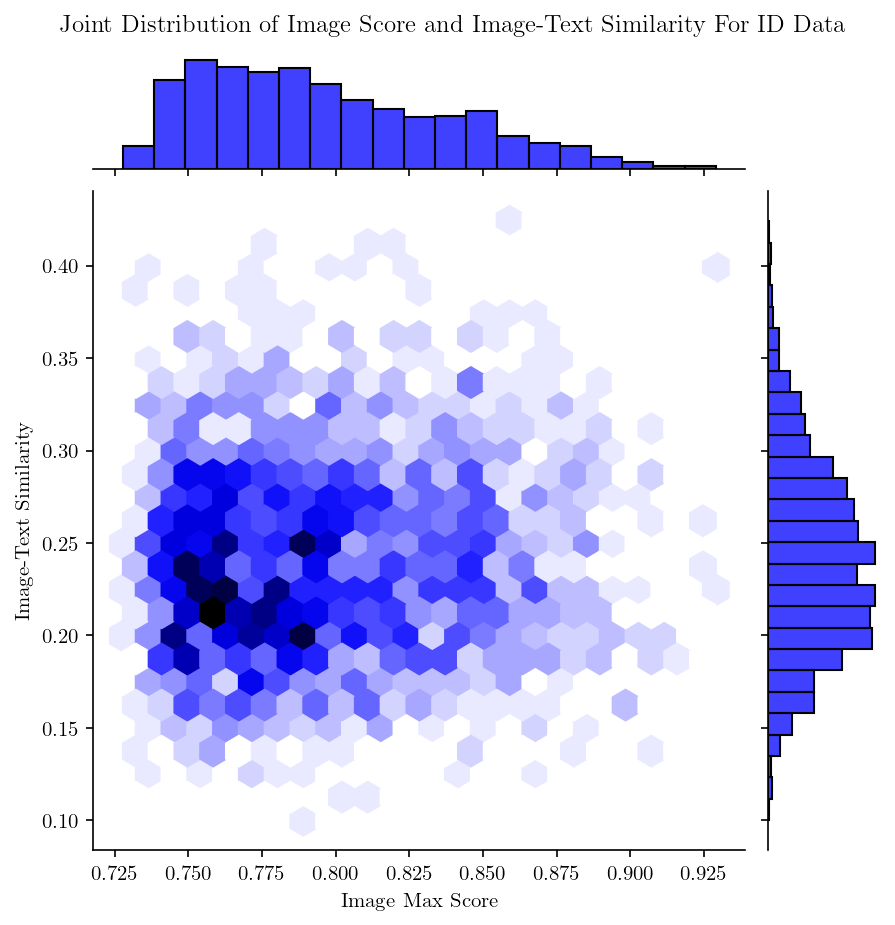

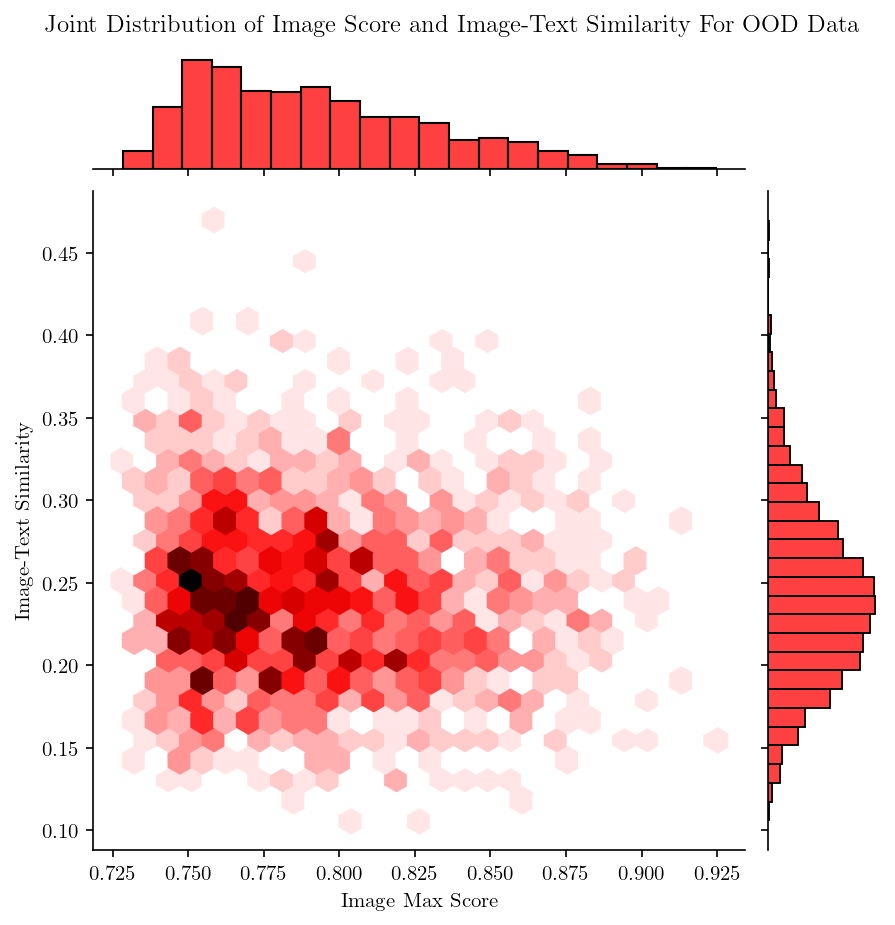

In [32]:
from utils import plot_figure

score_type = "energy"
type = "max"
mode = "image"
fpr = 95

plot_figure.plot_score_distribution(df_test, score_type, type, mode="image", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="dialogue", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall_transform", fpr=fpr)
#plot_figure.plot_kde_joint_distribution(df_test, score_type, type, mode)
plot_figure.plot_rough_distribution(df_test, 'image_text_similarity')
plot_figure.plot_rough_distribution(df_test, f'{score_type}_{type}_{mode}')
plot_figure.plot_joint_distribution(df_test, score_type, type, mode, id = 1, color = 'blue')
plot_figure.plot_joint_distribution(df_test, score_type, type, mode, id = 0, color = 'red')

In [33]:
# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, x[score].values, 0.95),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_sum_transform')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_max'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_max_transform')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity_max'),
        "Overall_Transform": eval_dict('msp_overall_simialrity_max_transform')
    },
    "Max Logits": {
        "Image": eval_dict('logits_max_image'),
        "Dialogue": eval_dict('logits_max_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_max'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_max_transform')
    },
    "Sum Logits": {
        "Image": eval_dict('logits_sum_image'),
        "Dialogue": eval_dict('logits_sum_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_sum_transform')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result_df = result[['Image', 'Dialogue', 'Overall', 'Overall_Transform']]
result_df.reset_index(inplace=True)
order = ['Energy Sum', 'Energy Max', 'MSP', 'Max Logits', 'Sum Logits']
result_df = result_df.set_index('Score').loc[order].reset_index()

In [34]:
result_df

Metric,Score,Image,Dialogue,Overall,Overall_Transform
0,Energy Sum,"[0.955, 0.514, 0.543]","[0.932, 0.583, 0.598]","[0.929, 0.585, 0.6]","[0.928, 0.556, 0.578]"
1,Energy Max,"[0.95, 0.526, 0.559]","[0.904, 0.602, 0.606]","[0.902, 0.604, 0.607]","[0.926, 0.59, 0.601]"
2,MSP,"[0.953, 0.511, 0.549]","[0.901, 0.603, 0.604]","[0.904, 0.602, 0.608]","[0.924, 0.562, 0.573]"
3,Max Logits,"[0.95, 0.526, 0.559]","[0.904, 0.602, 0.606]","[0.897, 0.604, 0.607]","[0.903, 0.604, 0.609]"
4,Sum Logits,"[0.969, 0.492, 0.526]","[0.971, 0.39, 0.445]","[0.971, 0.392, 0.448]","[0.968, 0.438, 0.48]"


In [ ]:
def convert_to_percentage(lst):
    return ' / '.join(f'{x*100:.1f}' for x in lst)

result_df['Image'] = result_df['Image'].apply(convert_to_percentage)
result_df['Dialogue'] = result_df['Dialogue'].apply(convert_to_percentage)
result_df['Overall'] = result_df['Overall'].apply(convert_to_percentage)
result_df['Overall_Transform'] = result_df['Overall_Transform'].apply(convert_to_percentage)

latex_table = result_df.to_latex(index=False, column_format='|l|c|c|c|c|', header=["Score", "Image", "Dialogue", "Overall", "Overall_Transform"], escape=False)

print(latex_table)

In [ ]:
def calculate_class_stats(model, train_loader):
    model.eval()
    class_means = []
    class_covariances = []
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in train_loader:
            data = data.cuda()
            features = model(data)
            all_features.append(features.cpu().numpy())
            all_labels.append(target.numpy())
    
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    for label in np.unique(all_labels):
        class_features = all_features[all_labels == label]
        class_mean = np.mean(class_features, axis=0)
        class_cov = np.cov(class_features, rowvar=False)
        class_means.append(class_mean)
        class_covariances.append(class_cov)
    
    return class_means, class_covariances

def mahalanobis_distance(x, mean, cov):
    x_minus_mean = x - mean
    inv_cov = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mean, inv_cov)
    mahalanobis_dist = np.sqrt(np.dot(left_term, x_minus_mean.T))
    return mahalanobis_dist

def calculate_ood_scores(model, test_loader, class_means, class_covariances):
    model.eval()
    ood_scores = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            features = model(data).cpu().numpy()
            
            for feature in features:
                min_distance = float('inf')
                for mean, cov in zip(class_means, class_covariances):
                    distance = mahalanobis_distance(feature, mean, cov)
                    if distance < min_distance:
                        min_distance = distance
                ood_scores.append(min_distance)
    
    return np.array(ood_scores)


## Results on OOD

# Without Mismatching Pair, Test ID instance 23233, Test OOD instance 6051


## Without image text similarity score
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.32, 0.952, 0.988]  |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.151, 0.974, 0.994] |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.885, 0.657, 0.889] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.331, 0.951, 0.988] |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.507, 0.927, 0.982] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.932, 0.788, 0.943] |

## With image text similarity score overall
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.346, 0.945, 0.986] |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.194, 0.97, 0.993]  |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.908, 0.574, 0.846] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.35, 0.945, 0.986]  |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.731, 0.793, 0.934] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.955, 0.764, 0.934] |

# With 5000 mismatching pairs, testing ID instance 23233, test OOD isntance 11051


## Without image text similarity
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.614, 0.758, 0.838] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.522, 0.767, 0.843] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.921, 0.598, 0.773] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.619, 0.758, 0.839] |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.707, 0.765, 0.848] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.953, 0.672, 0.814] |

## With imge text similarity score on overall 
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.598, 0.862, 0.932] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.511, 0.872, 0.934] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.752, 0.723, 0.831] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.607, 0.86, 0.931]  |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.569, 0.859, 0.924] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.975, 0.546, 0.709] |






